# Introduction to Machine Learning (CSCI-UA.473)
## Lab 11: Basic Clustering
### Date: April 20th, 2022

The goal of this lab is to practice implementing some basic clustering algorithms in sci-kit learn.  Specifically we will start with PCA, t-SNE and then move on to MDS and K-means.

In [1]:
# Import the necessary packages from sci-kit learn
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import vq # Specifically uesful for K-means clustering
from sklearn import cluster  # Clustering algorithms such as K-means and agglomerative

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans 
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import MDS #Import the multidimensional scaling module
from scipy.spatial.distance import squareform #Import squareform, which creates a symmetric matrix from a vector
import time
import math

In [2]:
df = datasets.load_digits(as_frame=True)
X,y = df.data, df.target
print(X.shape, y.shape)

(1797, 64) (1797,)


In [3]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

PCA(n_components=2, whiten=True)

In [4]:
X_pca = pca.transform(X)

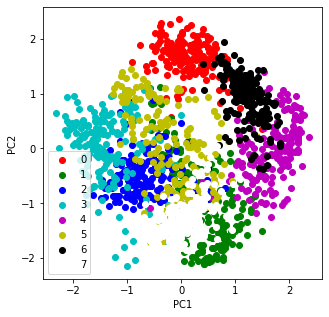

In [5]:
target_ids = range(len(df.target_names))
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, 'rgbcmykw', df.target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], c=c, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## T-distributed Stochastic Neighbor Embedding (t-SNE) using scikit-learn

A statistical method for visualizing high-dimensional data by giving each datapoint a location in either a two or three-dimensional space which can be easily visualized using a scatter plot. It is not recommended for use in analysis such as clustering or outlier detection since it does not necessarily preserve densities or distances well.

In [6]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1797, 2)

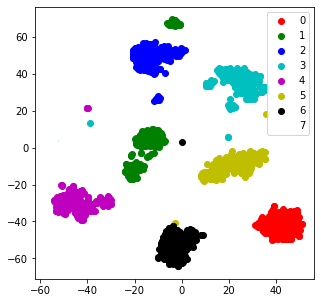

In [7]:
target_ids = range(len(df.target_names))
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, 'rgbcmykw', df.target_names):
    plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

## Multi-Dimensional Scaling 

Let's load a custom dataset based on academic disciplines.

In [8]:
data = np.genfromtxt('fieldsMDS.csv',delimiter=',') # load file as data
dataVec = np.ndarray.flatten(data) #Turning the matrix into a vector of pairwise distances
dataVec = dataVec[~np.isnan(dataVec)] #Remove all nans to leave only pairwise distances remaining
D = squareform(dataVec) #Create the distance matrix
fieldNames = ['Math', 'Physics', 'Chemistry', 'Biology', 'Psych', 'Neuro', 'Econ', 'Sociology', 'DS', 'CS']; #These are the academic fields

In [9]:
mds = MDS(n_components=2, n_init=100, max_iter = 10000, dissimilarity='precomputed') #Create the mds object
#Components: Looking for a 2D solution, n_init: Number of runs with random initial starting positions, max_iter: Max number of iterations per run, dissimilarity: We already did it, from out distance matrix, 
mdsSolution = mds.fit_transform(D) #Actually run the mds


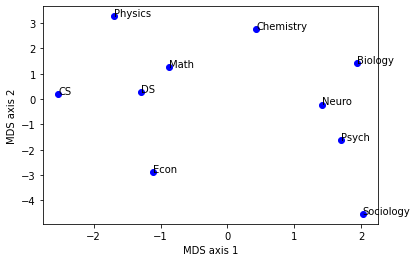

20.85931866250406


In [10]:
plt.scatter(mdsSolution[:,0], mdsSolution[:,1], color='blue') #Making the plot, first 2 dimensions
for ii in range(len(mdsSolution)):
    plt.text(mdsSolution[ii,0], mdsSolution[ii,1],fieldNames[ii])

plt.xlabel('MDS axis 1')
plt.ylabel('MDS axis 2')
plt.show()

print(mds.stress_) #How low could we get the stress? [Un-normalized]

## K-means Clustering

We'll start by looking at the sci-kit learn implementation of K-means for a synthetic dataset that has distinct clusters.  The cell below generates a synthetic dataset with 4 well-separated clusters.

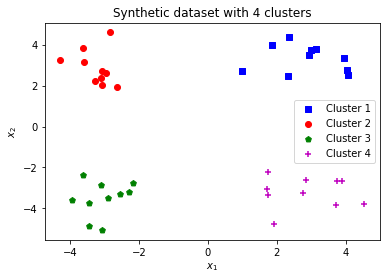

In [11]:
# Generate the synthetic dataset.
X1 = np.random.multivariate_normal(size = 10, mean = np.array([3, 3]), cov = np.identity(2))
X2 = np.random.multivariate_normal(size = 10, mean = np.array([-3, 3]), cov = np.identity(2))
X3 = np.random.multivariate_normal(size = 10, mean = np.array([-3, -3]), cov = np.identity(2))
X4 = np.random.multivariate_normal(size = 10, mean = np.array([3, -3]), cov = np.identity(2))

X = np.vstack([X1,X2,X3,X4])
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 's', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = 'o', label = 'Cluster 2')
plt.scatter(X3[:,0], X3[:,1], c = 'g', marker = 'p', label = 'Cluster 3')
plt.scatter(X4[:,0], X4[:,1], c = 'm', marker = '+', label = 'Cluster 4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Synthetic dataset with 4 clusters')
plt.legend()
plt.show()

## Distortion

A key quantity in helping determine a good number of clusters to use is the distortion
$$
J = \sum_{i=1}^N \|{\bf x}_i - \mu_{C(i)}\|^2
$$
where ${\bf x}_i$ are the data points, $C(i) \in \{1,\ldots,K\}$ is the cluster assignment for ${\bf x}_i$ and $\mu_j$ for $j=1,\ldots,K$ are the centers of the clusters.  Intuitively, the distortion captures the unexplained variation in the dataset after accounting for the clusters.  If $K = N$, then $\mu_{C(i)} = {\bf x}_i$ and the distortion will be 0.  In this case there is a cluster at every data point so intuitively there is no unexplained variation.  However, having a large number of clusters is often not very useful since we will likely be overfitting to noise in the data.  There will often be a certain point where the distortion starts to decrease more slowly.  This is called the "elbow method", which is what we plot below.

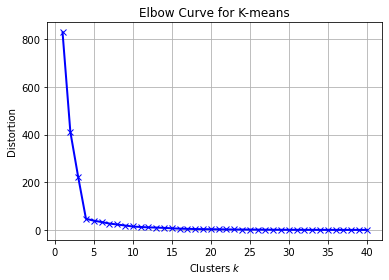

In [12]:
# Array to keep track of the distortions for K=1,...,N.
distortions = np.zeros(len(X))

for k in range(1, len(X) + 1):
    kmeans = cluster.KMeans(k) # K-means object in sci-kit learn with k clusters.
    kmeans.fit(X)              # This is the line that actually runs the K-means algorithm.
    distortions[k-1] = kmeans.inertia_ # In sci-kit learn the distortion is called the inertia.

# Plot the results.
plt.plot(np.arange(1, len(X)+1, 1), distortions, 'b-x', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Distortion')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

Indeed we see from the plot above that the distortion decreases rapidly up until $k=4$, which was the true number of clusters for our data.  After this point we begin overfitting to the noise and the distortion will not decrease as much.  A general heuristic is to choose $k$ where the kink, or elbow, in the curve occurs. 

This data was well-separated, however.  Let's see how the distortion behave whenever there is overlap between the clusters.  The cell below generates the new fake dataset with the clusters closer together.

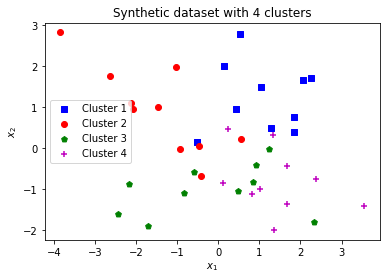

In [13]:
# Generate the new synthetic dataset.  The only difference from before is that the means are closer together now.
X1 = np.random.multivariate_normal(size = 10, mean = np.array([1, 1]), cov = np.identity(2))
X2 = np.random.multivariate_normal(size = 10, mean = np.array([-1, 1]), cov = np.identity(2))
X3 = np.random.multivariate_normal(size = 10, mean = np.array([-1, -1]), cov = np.identity(2))
X4 = np.random.multivariate_normal(size = 10, mean = np.array([1, -1]), cov = np.identity(2))

X = np.vstack([X1,X2,X3,X4])
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 's', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = 'o', label = 'Cluster 2')
plt.scatter(X3[:,0], X3[:,1], c = 'g', marker = 'p', label = 'Cluster 3')
plt.scatter(X4[:,0], X4[:,1], c = 'm', marker = '+', label = 'Cluster 4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Synthetic dataset with 4 clusters')
plt.legend()
plt.show()

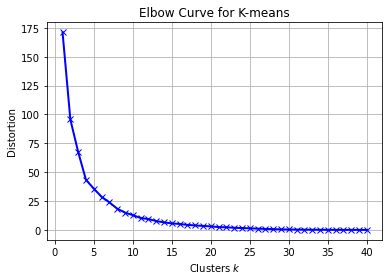

In [14]:
# Array of the distortions for k=1,...,N.
distortions = np.zeros(len(X))

# Same code as before.
for k in range(1, len(X) + 1):
    kmeans = cluster.KMeans(k)
    kmeans.fit(X)
    distortions[k-1] = kmeans.inertia_

# Plot the results.
plt.plot(np.arange(1, len(X)+1, 1), distortions, 'b-x', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Distortion')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

Now there is a more gradual decrease in the distortion and it is not as clear what choice of $k$ one should use.  

## Initializing the Cluster Centers 
One feature of K-means is that it is prone to becoming stuck in local minimum and is therefore sensitive to the initial cluster centers that are chosen.  The scipy implementation `kmeans2` allows for more flexibility in choosing the initial conditions so we also show it here as an alternative to sci-kit's implementation.  Now we see how the distortion changes after each iteration in K-means for different initializations.

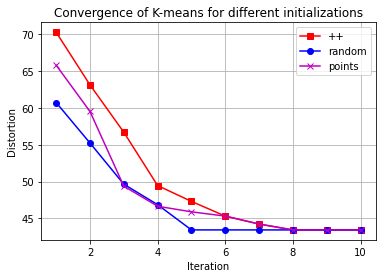

In [15]:
# Plot the distortion vs iteration for three different initial means.

# Helper function to compute the distortion using the data X and the computed cluster centers
# and labels for each point.
def distortion(X, centers, labels):
    N = X.shape[0]
    J = 0
    for i in range(N):
        J += np.linalg.norm(X[i] - centers[labels[i]])**2
    return J

# Only use 10 iterations of K-means.
max_iter = 10
distortions_1 = np.zeros(max_iter)
distortions_2 = np.zeros(max_iter)
distortions_3 = np.zeros(max_iter)

# 3 different initializations.
K = 4 # 4 clusters
np.random.seed(325) # Random seed is only chosen to emphasize difference between initializations.
                    # This line could be removed.
centers1, labels1 = vq.kmeans2(data = X, k = K, iter = 1, minit = '++')      # k-means++ initialization
centers2, labels2 = vq.kmeans2(data = X, k = K, iter = 1, minit = 'random')  # points sampled from a Gaussian
centers3, labels3 = vq.kmeans2(data = X, k = K, iter = 1, minit = 'points')  # points chosen from the dataset

distortions_1[0] = distortion(X, centers1, labels1)
distortions_2[0] = distortion(X, centers2, labels2)
distortions_3[0] = distortion(X, centers3, labels3)

for i in range(1, max_iter):
    # Do 1 iteration of K-means using the cluster centers from the last iteration.
    centers1, labels1 = vq.kmeans2(data = X, k = centers1, iter = 1, minit = 'matrix')
    centers2, labels2 = vq.kmeans2(data = X, k = centers2, iter = 1, minit = 'matrix')
    centers3, labels3 = vq.kmeans2(data = X, k = centers3, iter = 1, minit = 'matrix')
    
    distortions_1[i] = distortion(X, centers1, labels1)
    distortions_2[i] = distortion(X, centers2, labels2)
    distortions_3[i] = distortion(X, centers3, labels3)

# Plot the results
plt.plot(np.arange(1, max_iter + 1), distortions_1, 'r-s', label = '++')
plt.plot(np.arange(1, max_iter + 1), distortions_2, 'b-o', label = 'random')
plt.plot(np.arange(1, max_iter + 1), distortions_3, 'm-x', label = 'points')
plt.xlabel(r'Iteration')
plt.ylabel(r'Distortion')
plt.title(r'Convergence of K-means for different initializations')
plt.legend()
plt.grid()
plt.show()

The fact that all three curves have leveled-off indicates the K-means has converged.  However, the distortion is different meaning we have congevered to different local optima.

## MiniBatch KMeans
Given: `k`, mini-batch size `b`, iterations `t`, data set `X`
Initialize each $c \in C$ with an `x` picked randomly from `X`
```python
v ← 0
for i = 1 to t do
      M ← b examples picked randomly from X
      for x ∈ M do
            d[x] ← f (C, x)         // Cache the center nearest to x
      end for
      for x ∈ M do
            c ← d[x]                // Get cached center for this x
            v[c] ← v[c] + 1         // Update per-center counts
            η ← 1 / v[c]            // Get per-center learning rate
            c ← (1 − η)c + ηx       // Take gradient step
      end for
end for
```

In [ ]:
# Generate sample data
# Try 3e+3, 1e+4, 1e+5, 1e+6, 1e+7
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = datasets.make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [ ]:
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
print("Time KMeans: ", t_batch)

In [ ]:
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
print(t_mini_batch)

Now lets see whether the two algorithms lead to similar cluster assignments or not. 

In [ ]:
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
stepSize = math.floor(X.shape[0]/1000) # plot 10000 points only
Xplot = X[0:-1:stepSize, :]
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(Xplot, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(Xplot, mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(Xplot[my_members, 0], Xplot[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(Xplot[my_members, 0], Xplot[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(Xplot[identic, 0], Xplot[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(Xplot[different, 0], Xplot[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()